In [1]:
import torch
import torch.nn.functional as F
import vot
import sys
import time
import cv2
import importlib
import numpy as np
import collections
import aot.dataloaders.video_transforms as tr

sys.path.append('./aot')
sys.path.append('./aot/configs')

from torchvision import transforms
from aot.networks.models import build_vos_model
from aot.networks.engines import build_engine
from aot.utils.checkpoint import load_network



class AOTTracker(object):
    def __init__(self, cfg, gpu_id):
        self.gpu_id = gpu_id
        self.model = build_vos_model(cfg.MODEL_VOS, cfg).cuda(gpu_id)
        self.model, _ = load_network(self.model, cfg.TEST_CKPT_PATH, gpu_id)
        self.engine = build_engine(cfg.MODEL_ENGINE,
                                   phase='eval',
                                   aot_model=self.model,
                                   gpu_id=gpu_id,
                                   long_term_mem_gap=cfg.TEST_LONG_TERM_MEM_GAP)
        self.transform = transforms.Compose([
                            tr.MultiRestrictSize(cfg.TEST_MIN_SIZE, cfg.TEST_MAX_SIZE,
                                                cfg.TEST_FLIP, cfg.TEST_MULTISCALE,
                                                cfg.MODEL_ALIGN_CORNERS),
                            tr.MultiToTensor()
                        ])

    def add_reference_frame(self, frame, mask):
        frame = self.transform({'current_img': frame})[0]['current_img'].unsqueeze(0).float().cuda(self.gpu_id)
        # mask = F.interpolate(mask, size=frame.shape, mode='nearest')
        mask = self.transform({'current_img': mask})[0]['current_img'].unsqueeze(0).float().cuda(self.gpu_id)
        # print('frame:', frame.shape)
        # print('mask:', mask.shape)
        # exit()
        self.engine.add_reference_frame(frame, mask, frame_step=0, obj_nums=1)

    
    def track(self, image, output_height=512, output_width=512):
        image = self.transform({'current_img': image})[0]['current_img'].unsqueeze(0).float().cuda(self.gpu_id)
        self.engine.match_propogate_one_frame(image)
        pred_logit = self.engine.decode_current_logits(
                        (output_height, output_width))
        pred_prob = torch.softmax(pred_logit, dim=1)
        pred_label = torch.argmax(pred_prob, dim=1,
                                    keepdim=True).float()
        _pred_label = F.interpolate(pred_label,
                                    size=self.engine.input_size_2d,
                                    mode="nearest")
        self.engine.update_memory(_pred_label)
        conf = torch.mean(pred_prob * pred_label)
        return _pred_label, conf


def make_full_size(x, output_sz):
    '''
    zero-pad input x (right and down) to match output_sz
    x: numpy array e.g., binary mask
    output_sz: size of the output [width, height]
    '''
    if x.shape[0] == output_sz[1] and x.shape[1] == output_sz[0]:
        return x
    pad_x = output_sz[0] - x.shape[1]
    if pad_x < 0:
        x = x[:, :x.shape[1] + pad_x]
        # padding has to be set to zero, otherwise pad function fails
        pad_x = 0
    pad_y = output_sz[1] - x.shape[0]
    if pad_y < 0:
        x = x[:x.shape[0] + pad_y, :]
        # padding has to be set to zero, otherwise pad function fails
        pad_y = 0
    return np.pad(x, ((0, pad_y), (0, pad_x)), 'constant', constant_values=0)

engine_config = importlib.import_module('configs.' + 'pre_ytb_dav')
cfg = engine_config.EngineConfig('test', 'aott')
cfg.TEST_CKPT_PATH = 'aot/pretrain_models/AOTT_PRE_YTB_DAV.pth'
tracker = AOTTracker(cfg, 0)



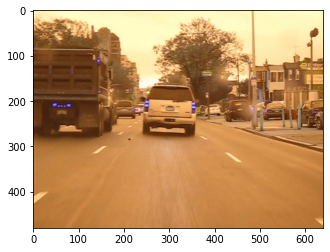

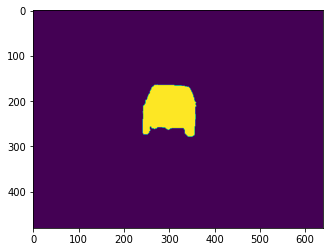

image0 (480, 640, 3)
mask0 (480, 640)


/home/sunchao/anaconda3/envs/vot/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/sunchao/vot_challenge/src/./aot/networks/layers/position.py:63: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature**(2 * (dim_t // 2) / self.num_pos_feats)


In [2]:
from vot.region.io import read_trajectory, parse_region


def make_full_mask(Mask, output_sz):
    mask, offset = Mask.mask, Mask.offset
    pad = np.zeros(output_sz)
    mask_w, mask_h = mask.shape
    pad[offset[1]: offset[1] + mask_w, offset[0]: offset[0] + mask_h] = mask
    return pad

video = 'car1'
image0_path = f'/home/sunchao/vot_challenge/sequences/{video}/color/00000001.jpg'
image1_path = f'/home/sunchao/vot_challenge/sequences/{video}/color/00000002.jpg'
path = f'/home/sunchao/vot_challenge/sequences/{video}/groundtruth.txt'
image0 = cv2.imread(image0_path)
image1 = cv2.imread(image1_path)
import matplotlib.pyplot as plt
plt.imshow(image0)
plt.show()


masks = read_trajectory(path)
m0 = masks[0]

mask0 = make_full_mask(m0, (image0.shape[0], image0.shape[1]))
import matplotlib.pyplot as plt
plt.imshow(mask0)
plt.show()
tracker.add_reference_frame(image0, mask0)
print('image0', image0.shape)
print('mask0', mask0.shape)
m, conf = tracker.track(image1)

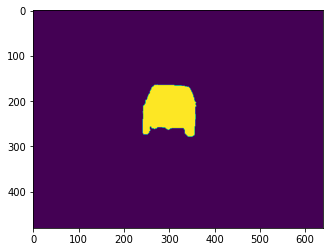

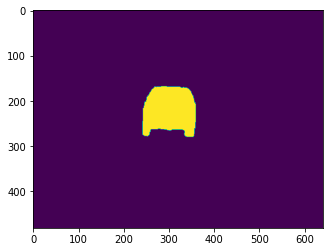

In [3]:
import matplotlib.pyplot as plt
plt.imshow(mask0)
plt.show()
plt.imshow(m[0][0].detach().cpu().numpy())
plt.show()